In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!nvidia-smi

Fri Mar 19 00:58:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.87       Driver Version: 456.87       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P8     7W /  N/A |   1418MiB /  6144MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
from   torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [5]:
#X = np.load("X_EEG.npy")
#y = np.load("y_EEG.npy")
#etadata = pd.read_csv("/metadata_EEG.csv")
from RandSamp import getSamples, getSamplOrig
from moabb.datasets import BNCI2014001
from moabb.paradigms import (LeftRightImagery, MotorImagery,
                         FilterBankMotorImagery)
# Extraer los datos
dataset = BNCI2014001()
# Cargar el paradigma a usar
paradigm = MotorImagery(n_classes=4,
                    fmin=8,
                    fmax=35,
                    tmin=-2,
                    tmax=5)

Choosing from all possible events


In [11]:
#X2 = X#np.array([[x[:, :1000]] for x in X])
#np.shape(X2)
X, y, metadata = paradigm.get_data(dataset=dataset, subjects=[1,2,3,4,5,6,7,8,9])

In [12]:
X2 = X#np.array([[x[:, :1000]] for x in X])
np.shape(X2)

(5184, 22, 1751)

In [18]:
X_train = X2[(metadata["session"]=="session_T")]
y_train = y[(metadata["session"]=="session_T")]

X_test = X2[(metadata["session"]=="session_E")]
y_test = y[(metadata["session"]=="session_E")]

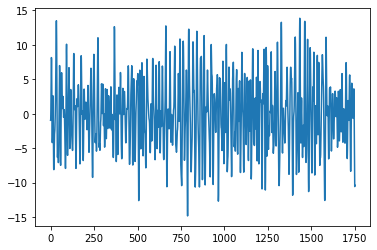

In [19]:
plt.plot(X_train[0, 0])

In [20]:
mxx = np.max(X_train) / 4
X_train = (X_train / mxx)
X_test = (X_test / mxx)

#X_train = torch.from_numpy(X_train).float().cuda()
#X_test = torch.from_numpy(X_test).float().cuda()

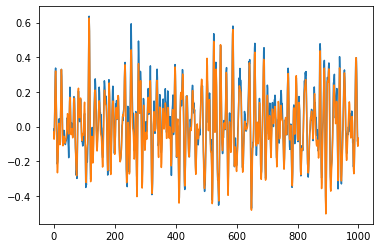

In [44]:
samples, originals = getSamplOrig(X_train, samples=10, ruido="eog", ns=7000)
plt.plot(samples[0, 0])
plt.plot(originals[0, 0])

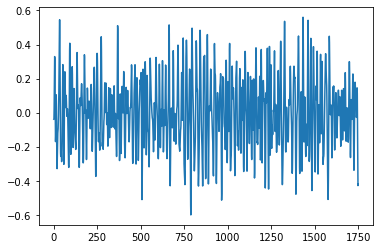

In [16]:
plt.plot(X_train[0, 0,].cpu())

In [10]:
dataloader = DataLoader(X_train, batch_size=128, shuffle=True)

In [47]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        #### Encoder
        self.conv1 = nn.Sequential(
            nn.Conv1d(22, 32, 16), 
            nn.ELU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, 12),  
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, 12),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, 12),
            nn.ELU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(2),  
        )

        
        
        ### Decoder 
        self.convt1 = nn.Sequential(
            nn.ConvTranspose1d(256, 128, 12, 2), 
            nn.ELU(),
            nn.BatchNorm1d(128),
        )
        
        self.convt2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 16, 2), 
            nn.ELU(),
            nn.BatchNorm1d(64),
        )
        
        self.convt3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 16, 2), 
            nn.ELU(),
            nn.BatchNorm1d(32),
        )
        
        self.convt4 = nn.Sequential(
            nn.ConvTranspose1d(32, 22, 22, 2), 
            nn.Tanh()
        )
        
        self.encoder = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
        )
        
        self.decoder = nn.Sequential(
            self.convt1,
            self.convt2,
            self.convt3,
            self.convt4,
        )

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    

    

In [48]:
torch.cuda.empty_cache()
learning_rate = 0.001
autoencoder = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [49]:
Cost = []
#encoder.train()
#decoder.train()

autoencoder.train()
for epoch in range(200):
    runnning_loss = 0
    samples, originals = getSamplOrig(X_train, samples=10, ruido="eog", ns=10000)
    samples = torch.from_numpy(samples).float().cuda()
    originals = torch.from_numpy(originals).float().cuda()

    # ===================forward=====================
    #encoded = encoder(data)
    output = autoencoder(samples)[:, :22, :1000]
    loss = criterion(output, originals[:, :22, :1000])
    Cost.append(loss.item())
    runnning_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 25 == 24:
        print("Epoca: ", epoch, " loss: ", runnning_loss)
        running_loss = 0



Epoca:  24  loss:  0.06794515252113342
Epoca:  49  loss:  0.046105530112981796
Epoca:  74  loss:  0.043447043746709824
Epoca:  99  loss:  0.045552678406238556
Epoca:  124  loss:  0.03163957595825195
Epoca:  149  loss:  0.03148201107978821
Epoca:  174  loss:  0.0319080650806427
Epoca:  199  loss:  0.03312455117702484


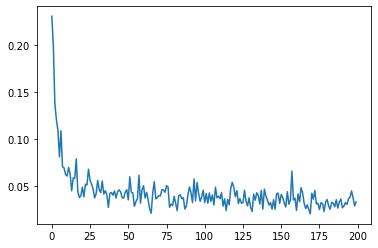

In [51]:
#with torch.no_grad():
#    out = autoencoder.encoder(data)
plt.plot(Cost)

In [52]:
print(out.shape)
print(autoencoder(data).shape)

NameError: name 'out' is not defined

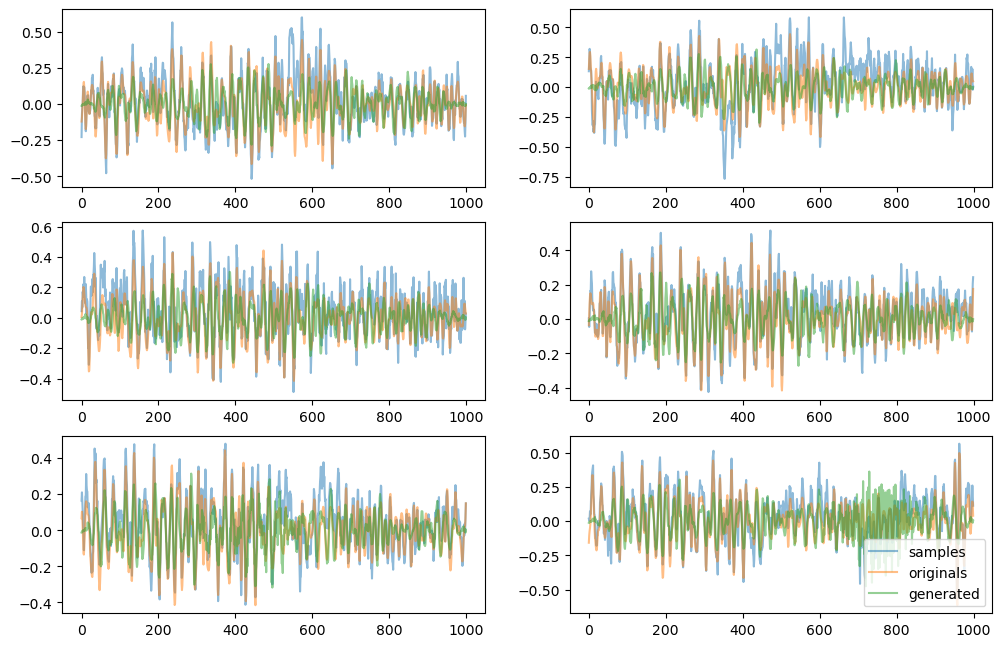

In [56]:
autoencoder.eval()
with torch.no_grad():
    output = autoencoder(samples)[:, :22, :1000]

plt.figure(figsize=(12, 8), dpi=100)
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.plot(samples[i,0].cpu().numpy(),
             label="samples",
            alpha=0.5)
    plt.plot(originals[i,0].cpu().numpy(),
             label="originals",
            alpha=0.5)
    plt.plot(output[i,0].cpu().numpy(),
             label="generated",
            alpha=0.5)

plt.legend()
plt.show()

In [57]:
output.max()

tensor(0.9254, device='cuda:0')

In [58]:
with torch.no_grad():
    encoded = autoencoder.encoder(data)

NameError: name 'data' is not defined

In [59]:
encoded.shape

NameError: name 'encoded' is not defined

In [204]:
class Clf1D(nn.Module):
    def __init__(self):
        super(Clf1D, self).__init__()
        

        # Definir capas de caracteristicas
        self.conv1 = nn.Sequential(
            nn.Conv1d(22, 32, 16), 
            nn.ELU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, 12),  
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, 12),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )
        
        #self.conv4 = nn.Sequential(
        #    nn.Conv1d(128, 256, 10),
        #    nn.ELU(),
        #    nn.BatchNorm1d(256),
        #    nn.MaxPool1d(2),  
        #)


        # Definir etapa recurrente
        #self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size))
        self.hidden_cell = torch.zeros(1, 1, 32)
        self.recurrent = nn.GRU(128, 32,
                                batch_first=True, dropout=0.2)

        
        self.features = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            #self.conv4,
        )

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #1696
            #3680
            nn.Linear(3648, 256),  
            nn.ELU(),
            nn.Dropout(p=0.5),
            #nn.Linear(128, 32),  
            #nn.ELU(),
            #nn.Dropout(p=0.5),
            nn.Linear(256, 4), 
        )
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 32).requires_grad_().cuda()
        x = self.features(x)
        x = torch.transpose(x, 1, 2)
        x, self.hidden_cell = self.recurrent(x, h0)
        x = self.classifier(x)
        return x
            
    

In [205]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [208]:
get_n_params(classifier1D)

1085540

In [240]:
# Inicializar el modelo
torch.cuda.empty_cache()
classifier1D = Clf1D().cuda()

learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier1D.parameters(), lr=learning_rate)

In [179]:
#with torch.no_grad():
#    features = classifier1D.features(data)
#    features = torch.transpose(features, 1, 2)
#    rec, classifier1D.hidden_cell = classifier1D.recurrent(features)
#    out = classifier1D.classifier(rec)

In [209]:
#classifier1D.hidden_cell.shape
out.shape
#rec.shape

torch.Size([96, 4])

In [210]:
# Copiar los parámetros de uno a otr
for target_param, param in zip(classifier1D.features.parameters(), autoencoder.encoder.parameters()):
    target_param = param.clone()
    
# Congelar los parámetros y mandar a CUDA
#for param in classifier1D.features.parameters():
#    param.requires_grad = False
    

#classifier1D.cuda()

In [244]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc = LabelEncoder().fit(y)
y_enc = enc.transform(y)


subj= [1,3,8,9]


X_train = X[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_T")]
y_train = y_enc[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_T")]
X_test = X[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_E")]
y_test = y_enc[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_E")]
mxx = np.max(X_train) / 4
X_train = (X_train / mxx)
X_test = (X_test / mxx)

In [242]:
mxx = np.max(X_train) / 4
X_train = (X_train / mxx)[:, :, :1000]
X_test = (X_test / mxx)[:, :, :1000]

#X_train2 = torch.from_numpy(X_train).float().to(device)
#X_test2 = torch.from_numpy(X_test).float().to(device)

#y_train2 = torch.from_numpy(y_train).int().to(device)
#y_test2 = torch.from_numpy(y_test).int().to(device)


batchsz = 128 

#trainset = Dataset()

#trainloader = DataLoader(X_train2, batch_size=batchsz)
#testloader = DataLoader(X_test2, batch_size=batchsz)

#y_trainloader = DataLoader(y_train2, batch_size=batchsz)
#y_testloader = DataLoader(y_test2, batch_size=batchsz)

X_train_gpu = torch.from_numpy(X_train).float().cuda()
X_test_gpu = torch.from_numpy(X_test).float().cuda()
y_train_gpu = torch.from_numpy(y_train).float().cuda()
y_test_gpu = torch.from_numpy(y_test).float().cuda()


dataTrain = DataLoader(TensorDataset(X_train_gpu, y_train_gpu), batch_size=128, shuffle=True)
dataTest = DataLoader(TensorDataset(X_test_gpu, y_test_gpu), batch_size=128, shuffle=True)

In [263]:
classifier1D.train()
cost = []
running_loss = 0
for epoch in range(3000):
    x, t = getSamples(X_train, y_train, samples=15, ruido="eog", ns=100000)
    data = torch.from_numpy(x).float().cuda()
    t = torch.from_numpy(np.array(np.ravel(t))).long().cuda()
    output = classifier1D(data)
    loss = criterion(output, t)
    
    running_loss += loss.item()
    if epoch % 50==49:
        cost.append(running_loss)
        print(running_loss)
        running_loss = 0
    
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


54.35656303167343
54.10748761892319
55.50175780057907
54.27874732017517
54.410154938697815
54.242719650268555
54.073373436927795
54.24953591823578
54.96859246492386
55.15008020401001
54.087571799755096
54.266556322574615
54.28002464771271
54.109814405441284
53.568429589271545
53.64775377511978
52.858689188957214
53.96582293510437
52.53389263153076
53.74350094795227
53.728312969207764
53.636454701423645
53.37366098165512
53.66264909505844
54.620432019233704
51.83037042617798
53.18119376897812
53.351579546928406
53.11672800779343
52.535609006881714
52.888483107089996
53.028137147426605
52.49203199148178
52.90037781000137
51.67649692296982
51.96907675266266
52.092752516269684
52.10174024105072
52.687753677368164
52.46223729848862
51.567789912223816
51.5909418463707
52.69817626476288
51.21688687801361
53.7628173828125
52.10564583539963
52.1490443944931
51.57537341117859
51.91259682178497
52.652232587337494
50.720164120197296
51.109871089458466
51.816036343574524
50.33547192811966
51.681388

In [264]:
# Cargar datos originales
X2 = np.load("X_EEG.npy")
y2 = np.load("y_EEG.npy")
metadata = pd.read_csv("metadata_EEG.csv")

X2 = np.array([x[:, :1000] for x in X2])
y2 = enc.transform(y2)
#X_train2 = X2[(metadata["session"]=="session_T")]
#y_train2 = y2[(metadata["session"]=="session_T")]

#X_test2 = X2[(metadata["session"]=="session_E")]
#y_test2 = y2[(metadata["session"]=="session_E")]

subj = subj= [1,3,9]
X_train2 = X2[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_T")]
y_train2 = y2[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_T")]

X_test2 = X2[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_E")]
y_test2 = y2[(metadata["subject"].isin(subj)) & (metadata["session"]=="session_E")]

X_train2 = (X_train2 / mxx)[:, :, :1000]
X_test2 = (X_test2 / mxx)[:, :, :1000]

X_train_gpu = torch.from_numpy(X_train2).float().cuda()
X_test_gpu = torch.from_numpy(X_test2).float().cuda()
y_train_gpu = torch.from_numpy(y_train2).float().cuda()
y_test_gpu = torch.from_numpy(y_test2).float().cuda()


dataTrain = DataLoader(TensorDataset(X_train_gpu, y_train_gpu), batch_size=128, shuffle=True)
dataTest = DataLoader(TensorDataset(X_test_gpu, y_test_gpu), batch_size=128, shuffle=True)

In [265]:
classifier1D.eval()
with torch.no_grad():
    correct = 0
    for data in dataTrain:
        out = classifier1D(data[0])
        correct += (data[1].float() == torch.max(out,1)[1].float()).sum().cpu()

In [266]:
np.round(correct.item() / len(y_train), 3)

0.585

In [267]:
with torch.no_grad():
    correct = 0
    for data in dataTest:
        out = classifier1D(data[0])
        correct += (data[1].float() == torch.max(out,1)[1].float()).sum().cpu()

In [268]:
np.round(correct.item() / len(y_train), 3)

0.471

In [269]:
#torch.save(classifier1D.state_dict(), "Pesos_1_3_8_9")
len(y_train)/128

9.0

In [270]:
subj2 = [2,4,5,6,7,8]
X_out = X2[metadata["subject"].isin(subj2)]
y_out = y2[metadata["subject"].isin(subj2)]

#mxx = np.max(X_train) / 4
X_out = (X_out / mxx)[:, :, :1000]

X_out_gpu = torch.from_numpy(X_out).float().cuda()
y_out_gpu = torch.from_numpy(y_out).float().cuda()

dataOut = DataLoader(TensorDataset(X_out_gpu, y_out_gpu), batch_size=128, shuffle=True)

In [271]:
with torch.no_grad():
    correct = 0
    for data in dataOut:
        out = classifier1D(data[0])
        correct += (data[1].float() == torch.max(out,1)[1].float()).sum().cpu()

In [272]:
np.round(correct.item() / len(y_out), 3)

0.344

In [261]:
y_out.shape

(3456,)

In [262]:
2304/128

18.0

In [ ]:
torch.save(classifier1D.state_dict(), "Pesos_Transfer_Soft_Todos")